In [ ]:
#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [ ]:
train_csv = pd.read_csv("fashion-mnist_test.csv")
test_csv = pd.read_csv("fashion-mnist_train.csv")

In [ ]:
class FashionDataset(Dataset):
   
    
    def __init__(self, data, transform = None):
        
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.fashion_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [ ]:
# Data transformation into tensor
train_set = FashionDataset(train_csv, transform=transforms.Compose([transforms.ToTensor()]))
test_set = FashionDataset(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=10)
test_loader = DataLoader(train_set, batch_size=10)

In [ ]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

# Build CNN model

In [ ]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

## Model for CNN class

In [ ]:
model = FashionCNN()
error = nn.CrossEntropyLoss()

"""
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)
"""

'\nlearning_rate = 0.001\noptimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)\nprint(model)\n'

# Train the dataset and test on test data

In [ ]:
def train_cnn(model,train_loader,steps):
    
    count = 0

    loss_list = []
    iteration_list = []
    accuracy_list = []

    # Lists for knowing classwise accuracy
    predictions_list = []
    labels_list = []
    
    for step in steps:
        num_epochs = step[0]
        optimizer = torch.optim.Adam(model.parameters(), lr=step[1])
        print(step)

        for epoch in range(num_epochs):
            print('Epoch:',epoch)
            
            for images, labels in train_loader:
                train = Variable(images.view(10, 1, 28, 28))
                labels = Variable(labels)
                
                optimizer.zero_grad()

                outputs = model(train)
                loss = error(outputs, labels)                
                
                #Propagating the error backward
                loss.backward()
                
                # Optimizing the parameters
                optimizer.step()
            
                count += 1
                
                if not (count % 50):
                    print("Iteration: {}, Loss: {}".format(count, loss.data))

In [ ]:
steps = [[3,0.1],[3,0.03],[3,0.01],[3,0.003],[3,0.001],[3,0.0003],[3,0.0001]]

train_cnn(model,train_loader,steps)

[3, 0.1]
Epoch: 0
Iteration: 50, Loss: 23.78925895690918
Iteration: 100, Loss: 4.96776819229126
Iteration: 150, Loss: 4.371396064758301
Iteration: 200, Loss: 2.5491652488708496
Iteration: 250, Loss: 2.5544073581695557
Iteration: 300, Loss: 2.3481874465942383
Iteration: 350, Loss: 2.5594570636749268
Iteration: 400, Loss: 2.5862748622894287
Iteration: 450, Loss: 2.61613130569458
Iteration: 500, Loss: 2.951936721801758
Iteration: 550, Loss: 2.5018932819366455
Iteration: 600, Loss: 2.943903923034668
Iteration: 650, Loss: 2.4985413551330566
Iteration: 700, Loss: 2.7600860595703125
Iteration: 750, Loss: 2.8819496631622314
Iteration: 800, Loss: 2.7388722896575928
Iteration: 850, Loss: 3.0042550563812256
Iteration: 900, Loss: 2.3997912406921387
Iteration: 950, Loss: 2.5810294151306152
Iteration: 1000, Loss: 2.2771718502044678
Epoch: 1
Iteration: 1050, Loss: 2.242825508117676
Iteration: 1100, Loss: 2.5146684646606445
Iteration: 1150, Loss: 2.843367338180542
Iteration: 1200, Loss: 2.581465244293

In [ ]:
def test_cnn(model,test_loader):
            
    total = 0
    correct = 0
                
    for images, labels in test_loader:
        
        labels_list.append(labels)
    
        test = Variable(images.view(10, 1, 28, 28))

        with torch.no_grad():
            outputs = model(test)
            predictions = torch.max(outputs, 1)[1]
            predictions_list.append(predictions)
            correct += (predictions == labels).sum()
            total += len(labels)
                   
    accuracy = correct * 100 / total
    return accuracy


In [ ]:
acc = test_cnn(model,test_loader)


tensor(10.0400)

In [ ]:
int(acc)

# Loss and Accuracy

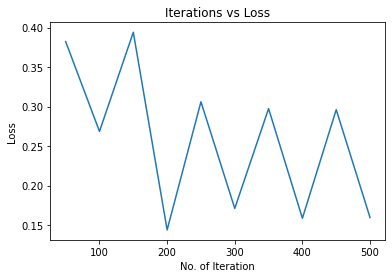

In [ ]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

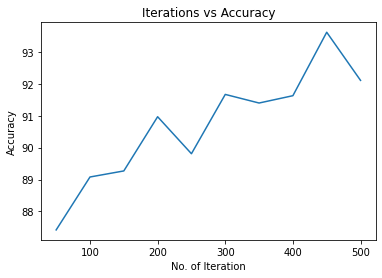

In [ ]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [ ]:
#Accuracy for each class
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 91.40%
Accuracy of Trouser: 95.60%
Accuracy of Pullover: 91.00%
Accuracy of Dress: 96.90%
Accuracy of Coat: 91.90%
Accuracy of Sandal: 99.10%
Accuracy of Shirt: 74.10%
Accuracy of Sneaker: 92.70%
Accuracy of Bag: 95.30%
Accuracy of Ankle Boot: 94.90%


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4f0cf6e9-5192-4efe-bedc-980e247a27b3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>